# Reinforcement Learning - Deep Q Network
If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**

In [1]:
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [2]:
%%execwritefile dqn_autograde.py
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting dqn_autograde.py


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Deep Q-Network (DQN)

In [4]:
import gym
env = gym.envs.make("CartPole-v1")

C:\Users\howar\anaconda3\envs\rl2020\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [5]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [6]:
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

### 2.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [7]:
%%execwritefile -a dqn_autograde.py

class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError

Appending to dqn_autograde.py


In [8]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1)
Q_net = QNetwork(num_hidden)

torch.manual_seed(1)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(Q_net(x).numpy(), test_model(x).numpy())

NotImplementedError: 

### 2.2 Experience Replay

In order to stabilize learning, we will use an experience replay to save states in and sample states from. Now implement the `push` function that adds a transition to the replay buffer, and the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`). It should keep at most the maximum number of transitions.

In [9]:
%%execwritefile -a dqn_autograde.py

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        # YOUR CODE HERE
        raise NotImplementedError

    def sample(self, batch_size):
        # YOUR CODE HERE
        raise NotImplementedError

    def __len__(self):
        return len(self.memory)

Appending to dqn_autograde.py


In [51]:
[x[0] for x in memory.sample(3)]

[array([-0.5036109,  0.       ]),
 array([-0.41584584,  0.        ]),
 array([-0.50313229,  0.        ])]

In [48]:
capacity = 10
# memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))

[(array([-0.50313229,  0.        ]), 0, -1.0, array([-0.50428569, -0.0011534 ]), False)]


### 2.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [ ]:
%%execwritefile -a dqn_autograde.py

def get_epsilon(it):
    # YOUR CODE HERE
    raise NotImplementedError
    return epsilon

In [ ]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])

Now write a function of *EpsilonGreedyPolicy* class. This function takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon. Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [ ]:
%%execwritefile -a dqn_autograde.py

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        raise NotImplementedError
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [ ]:
s = env.reset()
epg = EpsilonGreedyPolicy(Q_net, 0.05)
a = epg.sample_action(s)
assert not torch.is_tensor(a)
print (a)

### 2.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

In [ ]:
%%execwritefile -a dqn_autograde.py

def compute_q_vals(Q, states, actions):
    """
    This method returns Q values for given state action pairs.
    
    Args:
        Q: Q-net
        states: a tensor of states. Shape: batch_size x obs_dim
        actions: a tensor of actions. Shape: Shape: batch_size x 1

    Returns:
        A torch tensor filled with Q values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
    raise NotImplementedError
    
def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
    raise NotImplementedError

def train(Q, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [43]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(Q_net.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(Q_net, memory, optimizer, batch_size, discount_factor)

print (loss)

TypeError: tuple indices must be integers or slices, not tuple

### 2.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [ ]:
%%execwritefile -a dqn_autograde.py

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(Q.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        state = env.reset()
        
        steps = 0
        while True:
            # YOUR CODE HERE
            raise NotImplementedError
            
            if done:
                if i % 10 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                #plot_durations()
                break
    return episode_durations

In [12]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm
def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2F
            if done:
                if i % 10 == 0:
                    print(state)

                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                #plot_durations()
                break
    print(episode_durations)
  
    return episode_durations

In [2]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm
import gym 
def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)
    def forward(self, x):
        # YOUR CODE HERE
#         raise NotImplementedError
          out=self.l1(x)
          out=F.relu(out)
          out=self.l2(out)
        
          return out
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    def push(self, transition):
        # YOUR CODE HERE
#         raise NotImplemente
        self.memory.append(transition)
        if len(self.memory)>self.capacity:
            self.memory=self.memory[1:]
    def sample(self, batch_size):
        # YOUR CODE HERE
#         raise NotImplementedError
        return random.sample(self.memory,batch_size)
            
    def __len__(self):
        return len(self.memory)
def get_epsilon(it):
    # YOUR CODE HERE
#     raise NotImplementedError
    
    epsilon =np.maximum(1+ - .95*((it)/1000),.05)
    
    return epsilon
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  
        Args:
            obs: current state
        Returns:
            An action (int).
            
        """
        # YOUR CODE HERE
        
#         raise NotImplementedError
        with torch.no_grad():
            obs = torch.tensor(obs, dtype=torch.float)
            q=self.Q(obs)
            p=random.random()
#             print(p)
            if p<self.epsilon:
                return   int(len(q) * p/self.epsilon)
#             random.rand(),1)[0]
            else:
#                 print(self.Q(obs))
                return np.argmax(q).item()
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
def compute_q_vals(Q, states, actions):
#     """

    try:
        return torch.gather(Q.forward(states),1, actions)
    except:
        return Q_net.forward(state)[action].flatten()

    
def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """

    dones=dones.squeeze()
#     print(dones)
    ndmask=(1-dones.type(torch.FloatTensor))
    
    targets= rewards.squeeze()+(discount_factor*torch.max(Q(next_states),1)[0])*ndmask.flatten()

    return targets.reshape(len(dones),1)
# def compute_q_val(model, state, action):
#     return model(state)[torch.arange(state.shape[0]), action]
    
# def compute_target(model, reward, next_state, done, discount_factor):
#     return reward + discount_factor * model(next_state).max(dim=1).values * (1 - done).float()
def train(Q, memory, optimizer, batch_size, discount_factor,semi):
    # DO NOT MODIFY THIS FUNCTION
    loss_func = nn.MSELoss()
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
#     print(state)
#     reward=[]
#     for x in state:
#         if x[0]<0.5:
#             reward.append(x[0]+0.5)
#         else:
#             reward.append(x[0]+10)
#     reward=[x[0] for x in state]
    
#     print(reward)
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    if semi==True:
        with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
            target = compute_targets(Q, reward, next_state, done, discount_factor)
    else:
        target = compute_targets(Q, reward, next_state, done, discount_factor)

    # loss is measured from error between current and newly expected Q values
#     print(q_val)
#     print(target)
    loss = loss_func(q_val, target)
#     print(q_val.flatten())
#     print(target)
    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi):
#     print(episode_durations)
    optimizer = optim.Adam(Q.parameters(), learn_rate)

  
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = [] 
    global_iter = 0
    for i in range(num_episodes):
        state = env.reset()
        steps = 0
        while True:
            # YOUR CODE HERE
    #             raise NotImplementedError
            steps=steps+1
            epsilon=get_epsilon(global_steps)
            policy.set_epsilon(epsilon)
    #             epg = EpsilonGreedyPolicy(Q, epsilon)
            a = policy.sample_action(state)
            ns, reward, done, _ = env.step(a)
    #             print(done)
            memory.push((state, a, reward, ns, done))
            # if len(memory)>batch_size*3:
#                 for i in range(np.maximum(int(batch_size/episode_durations[-1]),5)):
            train(Q, memory, optimizer, batch_size, discount_factor,semi)
            state=ns
            global_steps=global_steps+1
#             print(reward)
            if done:
                if i % 10 == 0:
                    #print(state)

                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                #plot_durations()
                break
    print(episode_durations)
  
    return episode_durations

In [3]:
# Let's run it!
num_episodes = 1
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen
env = gym.envs.make("CartPole-v1")
semi = True

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden)
policy = EpsilonGreedyPolicy(Q_net, 0.05)
episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,semi)

C:\Users\tczin\AppData\Local\Continuum\anaconda3\envs\rl2020\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


 Episode 0 finished after 17 steps
[17]


Text(0.5, 1.0, 'Episode durations per episode')

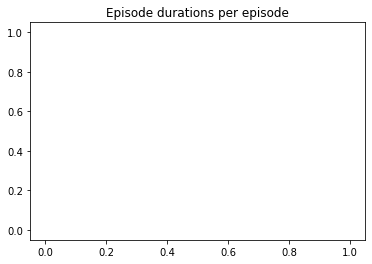

In [4]:
# And see the results
import matplotlib.pyplot as plt
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

## Run Semi-Gradient ##

In [7]:
import datetime as datetime
import pandas as pd

# Let's run it!
num_episodes = 1
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen#
results={}
results2={}
counter=0

x=datetime.datetime.now()
for seed in range(10):
    for semib in [True]:#,False]:
        for epsilon in [0.0]:#,.01,.05,.3]:
            for discount_factor in [1]:# [0.5,.8,1]:
# We will seed the algorithm (before initializing QNetwork!) for reproducibility
                random.seed(seed)
                torch.manual_seed(seed)
                env.seed(seed)

                Q_net = QNetwork(num_hidden)
                policy = EpsilonGreedyPolicy(Q_net, epsilon)
                episode_durations1 = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,semi=semib)
                
                results[counter]={'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}
                results2[counter]={'DQN':Q_net,'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}

                counter=counter+1
    print(datetime.datetime.now()-x)
results11=pd.DataFrame(results).T
results11.to_hdf('results.h5','df')

 Episode 0 finished after 21 steps
[21]
0:00:00.011970
 Episode 0 finished after 29 steps
[29]
0:00:00.028926
 Episode 0 finished after 17 steps
[17]
0:00:00.053858
 Episode 0 finished after 29 steps
[29]
0:00:00.116691
 Episode 0 finished after 12 steps
[12]
0:00:00.144617
 Episode 0 finished after 18 steps
[18]
0:00:00.186503
 Episode 0 finished after 11 steps
[11]
0:00:00.219417
 Episode 0 finished after 24 steps
[24]
0:00:00.271275
 Episode 0 finished after 27 steps
[27]
0:00:00.352060
 Episode 0 finished after 28 steps
[28]
0:00:00.419879


ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

## Run Full-Gradient ##

In [45]:
# Let's run it!
num_episodes = 1000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen#
results_full={}
results2_full={}
counter=0

x=datetime.datetime.now()
for seed in range(10):
    for semib in [False]:#,False]:
        for epsilon in [0.0]:#,.01,.05,.3]:
            for discount_factor in [1]:# [0.5,.8,1]:
# We will seed the algorithm (before initializing QNetwork!) for reproducibility
                random.seed(seed)
                torch.manual_seed(seed)
                env.seed(seed)

                Q_net = QNetwork(num_hidden)
                policy = EpsilonGreedyPolicy(Q_net, epsilon)
                episode_durations1 = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,semi=semib)
                
                results_full[counter]={'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}
                results2_full[counter]={'DQN':Q_net,'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}

                counter=counter+1
    print(datetime.datetime.now()-x)
#results11=pd.DataFrame(results).T
#results11.to_hdf('results.h5','df')

 Episode 0 finished after 21 steps
 Episode 10 finished after 17 steps
 Episode 20 finished after 12 steps
 Episode 30 finished after 16 steps
 Episode 40 finished after 44 steps
 Episode 50 finished after 37 steps
 Episode 60 finished after 57 steps
 Episode 70 finished after 52 steps
 Episode 80 finished after 49 steps
 Episode 90 finished after 34 steps
 Episode 100 finished after 35 steps
 Episode 110 finished after 27 steps
 Episode 120 finished after 82 steps
 Episode 130 finished after 40 steps
 Episode 140 finished after 44 steps
 Episode 150 finished after 27 steps
 Episode 160 finished after 59 steps
 Episode 170 finished after 59 steps
 Episode 180 finished after 15 steps
 Episode 190 finished after 43 steps
 Episode 200 finished after 105 steps
 Episode 210 finished after 37 steps
 Episode 220 finished after 73 steps
 Episode 230 finished after 128 steps
 Episode 240 finished after 112 steps
 Episode 250 finished after 55 steps
 Episode 260 finished after 170 steps
 Episode

KeyboardInterrupt: 

Text(0.5, 1.0, 'Episode durations per episode')

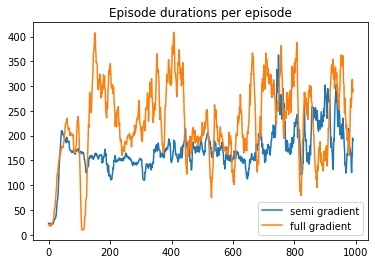

In [31]:
plt.plot(smooth(episode_durations, 10),label='semi gradient')
plt.plot(smooth(episode_durations1, 10),label='full gradient')
plt.legend()
plt.title('Episode durations per episode')

In [33]:
import pandas as pd
print(results11)
#results11 = pd.DataFrame(results).T
tmp = []
for i in range(10):
    tmp.append(results11.loc[i, 'EpisodeDuration'])
durations_np = np.array(tmp)
#mean = np.array(results11[0])
print(durations_np.shape)
mean = durations_np.mean(axis=0)
std = durations_np.std(axis=0)
print(mean.shape, std.shape)
#results11['EpisodeDuration'] = results11['EpisodeDuration']
#results11

                                     EpisodeDuration Seed SemiB Epsilon  \
0  [21, 16, 28, 17, 15, 34, 21, 16, 19, 41, 14, 1...    0  True       0   
1  [21, 26, 24, 27, 17, 24, 57, 14, 18, 15, 84, 6...    1  True       0   
2  [20, 29, 26, 11, 43, 17, 21, 20, 19, 12, 21, 1...    2  True       0   
3  [19, 12, 13, 29, 14, 20, 13, 9, 30, 15, 17, 17...    3  True       0   
4  [25, 18, 23, 38, 42, 15, 16, 22, 45, 43, 31, 1...    4  True       0   
5  [17, 17, 14, 28, 13, 21, 117, 45, 21, 17, 22, ...    5  True       0   
6  [25, 28, 9, 18, 14, 26, 14, 9, 18, 8, 12, 17, ...    6  True       0   
7  [18, 19, 26, 26, 11, 30, 24, 19, 37, 33, 27, 2...    7  True       0   
8  [70, 18, 17, 12, 15, 22, 13, 36, 9, 17, 10, 12...    8  True       0   
9  [24, 25, 11, 16, 39, 27, 30, 14, 12, 15, 18, 1...    9  True       0   

  DisFactor  
0         1  
1         1  
2         1  
3         1  
4         1  
5         1  
6         1  
7         1  
8         1  
9         1  
(10, 1000)
(1000,) (

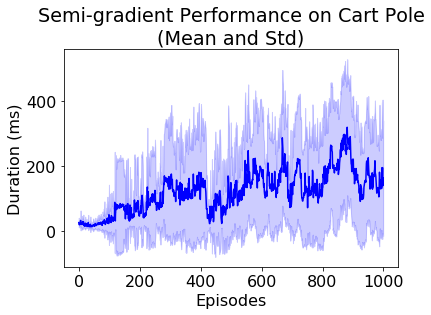

In [56]:
#plt.plot(len(mean), mean, 'or')
plt.rcParams.update({'font.size': 16})
plt.plot(range(len(mean)), mean, '-', color='blue')

plt.fill_between(range(len(mean)), mean-std, mean+std,
                 color='blue', alpha=0.2)
plt.xlabel('Episodes')
plt.ylabel('Duration (ms)')
plt.title('Semi-gradient Performance on Cart Pole\n(Mean and Std)')
plt.savefig('cart_pole_semi.pdf', bbox_inches='tight')

If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**